In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import numpy as np
import seaborn as sns
import os
import re
import time
import pickle
import pandas as pd
import sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

sns.set()

Using TensorFlow backend.
/Users/matt/anaconda3/envs/ML/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/matt/anaconda3/envs/ML/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/matt/anaconda3/envs/ML/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/matt/anaconda3/envs/ML/lib/p

## Train low SN variable Quasars & test on low

In [2]:
def reading_in_data(filename):
    
    filename = str(filename)

    infile = open(filename,'rb')
    new_dict = pickle.load(infile)
    infile.close()
    
    return new_dict

def creating_datasets(data_dict):
    
    train_images = data_dict['IMAGES'][:8265, :, :, :]
    train_labels = data_dict['LABELS'][:8265]

    val_images = data_dict['IMAGES'][8265:10035, :, :, :]
    val_labels = data_dict['LABELS'][8265:10035]

    test_images = data_dict['IMAGES'][10035:11806, :, :, :]
    test_labels = data_dict['LABELS'][10035:11806]
    
    data = {'TRAIN_IMG': train_images, 'TRAIN_LABELS': train_labels, 'VAL_IMAGES': val_images,\
            'VAL_LABELS': val_labels, 'TEST_IMG': test_images, 'TEST_LABELS': train_labels}


In [3]:
input_data_var = \
pd.read_pickle("/Users/matt/Desktop/DESI_Research/DESI_ML/var_CNN/Dictionaries/corrected_preprocessed_joined_obj_dict/var_star_preprocessed_data_low")




In [4]:
len(input_data_var['LABELS'])

4910

In [5]:
#input_data_var = reading_in_data("var_star_preprocessed_data_low")

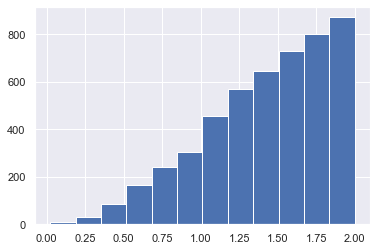

In [6]:
a,b,c = plt.hist(input_data_var['NOISE'], bins= 12)

In [7]:
# plt.plot(input_data_var['WAVE'][10000], input_data_var['FLUX'][10000], label = input_data_var['LABELS'][10000])
# plt.legend()

In [8]:
# train_images = input_data_var['IMAGES'][:1181, :, :, :]
# print(np.shape(train_images))
# train_labels = input_data_var['LABELS'][:1181]
# print(np.shape(train_labels))

# val_images = input_data_var['IMAGES'][1181:2362, :, :, :]
# print(np.shape(val_images))
# val_labels = input_data_var['LABELS'][1181:2362]
# print(np.shape(val_labels))

# test_images = input_data_var['IMAGES'][2362:, :, :, :]
# print(np.shape(test_images))
# test_labels = input_data_var['LABELS'][2362:]
# print(np.shape(test_labels))

### The code below is for a 70/15/15 split

In [9]:
train_images = input_data_var['IMAGES'][:3438, :, :, :]
print(np.shape(train_images))
train_labels = input_data_var['LABELS'][:3438]
print(np.shape(train_labels))

val_images = input_data_var['IMAGES'][3438:4174, :, :, :]
print(np.shape(val_images))
val_labels = input_data_var['LABELS'][3438:4174]
print(np.shape(val_labels))

test_images = input_data_var['IMAGES'][4174:4910, :, :, :]
print(np.shape(test_images))
test_labels = input_data_var['LABELS'][4174:4910]
print(np.shape(test_labels))

(3438, 1, 3681, 1)
(3438,)
(736, 1, 3681, 1)
(736,)
(736, 1, 3681, 1)
(736,)


Text(0.5, 1.0, 'stars are 1 & qsos are 0')

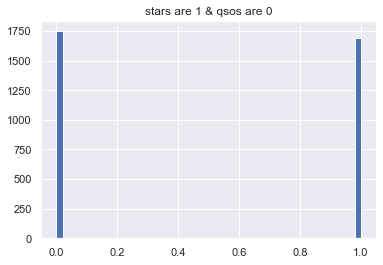

In [10]:
a,b,c = plt.hist(train_labels, bins=50)
plt.title('stars are 1 & qsos are 0')

Text(0.5, 1.0, 'stars are 1 & qsos are 0')

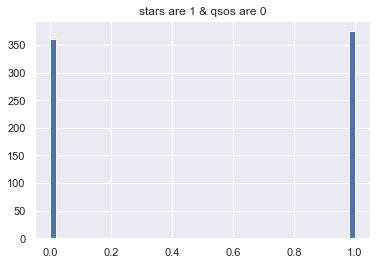

In [11]:
a,b,c = plt.hist(val_labels, bins=50)
plt.title('stars are 1 & qsos are 0')

Text(0.5, 1.0, 'stars are 1 & qsos are 0')

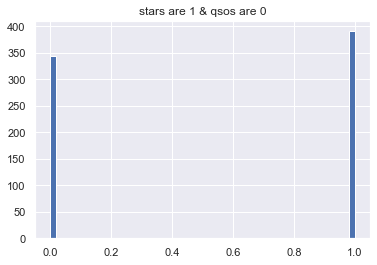

In [12]:
a,b,c = plt.hist(test_labels, bins=50)
plt.title('stars are 1 & qsos are 0')

In [13]:
unique, counts = np.unique(train_labels, return_counts=True)
dict(zip(unique, counts))

{0.0: 1749, 1.0: 1689}

In [14]:
unique, counts = np.unique(val_labels, return_counts=True)
dict(zip(unique, counts))

{0.0: 361, 1.0: 375}

In [15]:
unique, counts = np.unique(test_labels, return_counts=True)
dict(zip(unique, counts))

{0.0: 345, 1.0: 391}

In [16]:
# stars = []

# quasars = []

# for i in range(len(train_labels)):
    
#     if train_labels[i] == 1:
#         stars.append(train_labels[i])
        
#     elif train_labels[i] == 0.:
#         quasars.append(train_labels[i])
        
# print('# of QSOS =', len(quasars))
# print('# of stars =', len(stars))

In [17]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(12, (1, 12), activation='relu', input_shape=(1, 3681, 1), data_format='channels_last'))
model.add(keras.layers.MaxPooling2D( (1, 4)))

model.add(keras.layers.Conv2D(18, (1, 6), activation='relu', data_format='channels_last'))
model.add(keras.layers.MaxPooling2D((1, 4)))

model.add(keras.layers.Conv2D(24, (1, 6), activation='relu', data_format='channels_last'))
model.add(keras.layers.MaxPooling2D((1, 4)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units = 256, activation = 'relu'))
model.add(keras.layers.Dense(units = 1, activation = 'sigmoid'))


opt = keras.optimizers.SGD(lr = 5e-3, momentum = 0.25, decay = 1e-5)
model.compile(loss='binary_crossentropy', optimizer = opt  , metrics = ['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 3670, 12)       156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 917, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 912, 18)        1314      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 228, 18)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 223, 24)        2616      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 55, 24)         0         
_________________________________________________________________
flat

In [18]:
history = model.fit(train_images,
train_labels,
epochs= 80,
batch_size= 32,
validation_data=(val_images, val_labels))

Instructions for updating:
Use tf.cast instead.
Train on 3438 samples, validate on 736 samples
Epoch 1/80
3438/3438 [==============================] - 4s 1ms/step - loss: 0.6940 - acc: 0.4869 - val_loss: 0.6932 - val_acc: 0.5136
Epoch 2/80
3438/3438 [==============================] - 4s 1ms/step - loss: 0.6929 - acc: 0.5189 - val_loss: 0.6927 - val_acc: 0.5163
Epoch 3/80
3438/3438 [==============================] - 4s 1ms/step - loss: 0.6923 - acc: 0.5294 - val_loss: 0.6922 - val_acc: 0.4986
Epoch 4/80
3438/3438 [==============================] - 5s 1ms/step - loss: 0.6917 - acc: 0.5372 - val_loss: 0.6919 - val_acc: 0.4918
Epoch 5/80
3438/3438 [==============================] - 5s 1ms/step - loss: 0.6913 - acc: 0.5084 - val_loss: 0.6914 - val_acc: 0.4905
Epoch 6/80
3438/3438 [==============================] - 4s 1ms/step - loss: 0.6908 - acc: 0.5084 - val_loss: 0.6910 - val_acc: 0.4905
Epoch 7/80
3438/3438 [==============================] - 5s 1ms/step - loss: 0.6903 - acc: 0.5247 - va

3438/3438 [==============================] - 4s 1ms/step - loss: 0.0793 - acc: 0.9785 - val_loss: 0.1202 - val_acc: 0.9606
Epoch 60/80
3438/3438 [==============================] - 4s 1ms/step - loss: 0.0770 - acc: 0.9776 - val_loss: 0.0905 - val_acc: 0.9728
Epoch 61/80
3438/3438 [==============================] - 4s 1ms/step - loss: 0.0770 - acc: 0.9767 - val_loss: 0.0876 - val_acc: 0.9755
Epoch 62/80
3438/3438 [==============================] - 4s 1ms/step - loss: 0.0712 - acc: 0.9791 - val_loss: 0.0869 - val_acc: 0.9742
Epoch 63/80
3438/3438 [==============================] - 4s 1ms/step - loss: 0.0701 - acc: 0.9782 - val_loss: 0.0841 - val_acc: 0.9742
Epoch 64/80
3438/3438 [==============================] - 4s 1ms/step - loss: 0.0715 - acc: 0.9773 - val_loss: 0.1131 - val_acc: 0.9647
Epoch 65/80
3438/3438 [==============================] - 4s 1ms/step - loss: 0.0661 - acc: 0.9791 - val_loss: 0.0888 - val_acc: 0.9701
Epoch 66/80
3438/3438 [==============================] - 4s 1ms/ste

736/736 [==============================] - 0s 659us/step
Test loss = 0.08318113786694796
Test accuracy = 0.9714673913043478


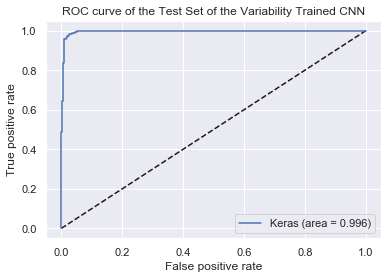

In [28]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test loss = ' +str(test_loss))
print('Test accuracy = ' +str(test_acc))

y_pred_keras = model.predict(test_images).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, y_pred_keras)

auc_keras = auc(fpr_keras, tpr_keras)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of the Test Set of the Variability Trained CNN')
plt.legend(loc='best')
plt.show()

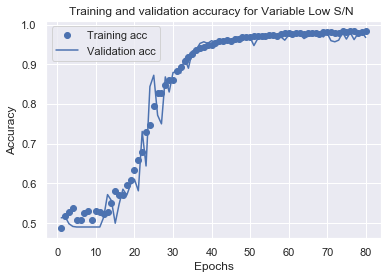

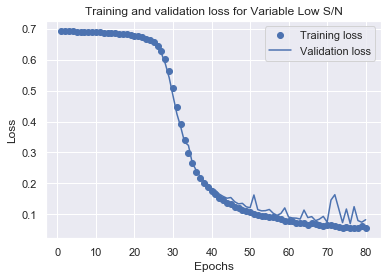

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy for Variable Low S/N ')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for Variable Low S/N')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
model.save('low_var_trained_CNN.h5')


## Train high SN Quasars & test on low

In [22]:
# input_data_quasar_high = reading_in_data("quasar_star_preprocessed_data_high")

# input_data_quasar_low = reading_in_data("quasar_star_preprocessed_data")

In [23]:
# train_images = input_data_quasar_high['IMAGES'][:8265, :, :, :]
# print(np.shape(train_images))
# train_labels = input_data_quasar_high['LABELS'][:8265]
# print(np.shape(train_labels))

# val_images = input_data_quasar_high['IMAGES'][8265:10035, :, :, :]
# print(np.shape(val_images))
# val_labels = input_data_quasar_high['LABELS'][8265:10035]
# print(np.shape(val_labels))

# test_images = input_data_quasar_low['IMAGES'][10035:11806, :, :, :]
# print(np.shape(test_images))
# test_labels = input_data_quasar_low['LABELS'][10035:11806]
# print(np.shape(test_labels))

In [24]:
# model = keras.Sequential()
# model.add(keras.layers.Conv2D(12, (1, 12), activation='relu', input_shape=(1, 3681, 1), data_format='channels_last'))
# model.add(keras.layers.MaxPooling2D( (1, 4)))

# model.add(keras.layers.Conv2D(18, (1, 6), activation='relu', data_format='channels_last'))
# model.add(keras.layers.MaxPooling2D((1, 4)))

# model.add(keras.layers.Conv2D(24, (1, 6), activation='relu', data_format='channels_last'))
# model.add(keras.layers.MaxPooling2D((1, 4)))

# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(units = 256, activation = 'relu'))
# model.add(keras.layers.Dense(units = 1, activation = 'sigmoid'))


# opt = keras.optimizers.SGD(lr = 5e-3, momentum = 0.25, decay = 1e-5)
# model.compile(loss='binary_crossentropy', optimizer = opt  , metrics = ['accuracy'])

# model.summary()

In [25]:
# history = model.fit(train_images,
# train_labels,
# epochs= 15,
# batch_size= 64,
# validation_data=(val_images, val_labels))

In [26]:
# test_loss, test_acc = model.evaluate(test_images, test_labels)

# print('Test loss = ' +str(test_loss))
# print('Test accuracy = ' +str(test_acc))